Monitoramento e fairness

In [64]:
import pandas as pd
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

Carregar modelos e vetor já treinados

In [65]:
model_path = "../model.joblib"
vector_path = "../vectorizer.joblib"
dataset_path = "../data/tweets_limpo.csv"

if not (os.path.exists(model_path) and os.path.exists(vector_path)):
   raise FileNotFoundError("Treine e salve o modelo antes de prosseguir.")

model = joblib.load(model_path)
vectorizer = joblib.load(vector_path)

df = pd.read_csv(dataset_path)
display(df.head())

,text,label,text_length
0,Adorei o produto de investimentos no mercado d...,positivo,56
1,O serviço de instalação internet doi péssimo. ...,negativo,59
2,Entrega rápida com atendimento excelente,positivo,40
3,Não voltarei a comprar,negativo,22
4,"Adorei o produto, superou minhas expectativas!",positivo,46


Monitoramento

In [66]:
new_texts = [
   'Muito ruim. Não gostei do atendimento.',
   'A entrega foi sensacional!',
   'Não funcionou. Me decepcionei.',
   'Recomendo para todos, nota 10!',
   'Recomendo para todos, top!',
]

new_df = pd.DataFrame({"text": new_texts})
display(new_df.head())

,text
0,Muito ruim. Não gostei do atendimento.
1,A entrega foi sensacional!
2,Não funcionou. Me decepcionei.
3,"Recomendo para todos, nota 10!"
4,"Recomendo para todos, top!"


Vetorizar e predizer

In [67]:
new_vectors = vectorizer.transform(new_df["text"])
new_preds = model.predict(new_vectors)

new_df['sentimento_predito'] = new_preds

print(new_df)


                                     text sentimento_predito
0  Muito ruim. Não gostei do atendimento.           negativo
1              A entrega foi sensacional!           positivo
2          Não funcionou. Me decepcionei.           negativo
3          Recomendo para todos, nota 10!           positivo
4              Recomendo para todos, top!           positivo


Porcentagem de cada classe

In [68]:
class_dist = new_df["sentimento_predito"].value_counts(normalize=True)
print("Distribuição dos sentimentos preditos nos novos dados:")
print(class_dist)

Distribuição dos sentimentos preditos nos novos dados:
sentimento_predito
positivo    0.6
negativo    0.4
Name: proportion, dtype: float64


Fairness - Vieses

In [69]:
df['text_length'] = df['text'].apply(len)
df['len_category'] = pd.cut(df['text_length'], bins=[0,50,150,1000], labels=['curto', 'medio', 'longo'])

display(df['len_category'])

0     medio
1     medio
2     curto
3     curto
4     curto
5     curto
6     curto
7     curto
8     curto
9     curto
10    curto
11    curto
12    curto
13    curto
14    curto
15    curto
Name: len_category, dtype: category
Categories (3, object): ['curto' < 'medio' < 'longo']

Predição do conjunto de validação

In [70]:
vetores = vectorizer.transform(df['text'])
df['pred'] = model.predict(vetores)
display(df['pred'])

0     positivo
1     negativo
2     positivo
3     negativo
4     positivo
5     negativo
6     positivo
7     negativo
8     positivo
9     negativo
10    positivo
11    negativo
12    positivo
13    positivo
14    positivo
15    negativo
Name: pred, dtype: object

Avaliação da acurácia

In [71]:
for cat in df['len_category'].unique():
    subset = df[df['len_category'] == cat]
    if not subset.empty:
        acuracia = (subset['label'] == subset['pred']).mean()
        print(f'Acurácia para textos {cat}: {acuracia:.2f} (N={len(subset)})')

Acurácia para textos medio: 1.00 (N=2)
Acurácia para textos curto: 1.00 (N=14)


Desafio fairness


Matriz de confusão para textos medio:
[[1 0]
 [0 1]]


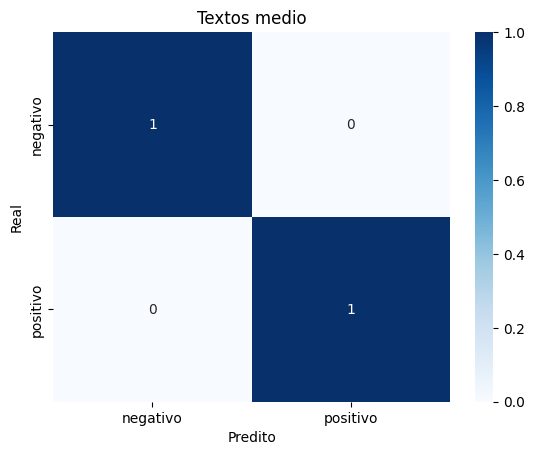


Matriz de confusão para textos curto:
[[6 0]
 [0 8]]


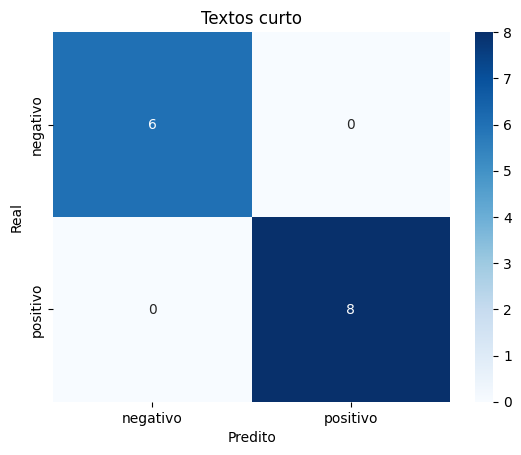

In [72]:
for cat in df['len_category'].unique():
   subset = df[df["len_category"] == cat]
   if not subset.empty:
      print(f"\nMatriz de confusão para textos {cat}:")
      print(confusion_matrix(subset['label'], subset["pred"]))
      sns.heatmap(confusion_matrix(subset['label'], subset["pred"]),
                  annot=True, fmt='d', cmap="Blues",
                  xticklabels=['negativo','positivo'],
                  yticklabels=['negativo','positivo']
                  )
      plt.title(f"Textos {cat}")
      plt.xlabel("Predito")
      plt.ylabel("Real")
      plt.show()